## Setup PyDrake using underactuated in Google Colab

In [10]:
import sys
import importlib
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('pydrake') is None:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

## Import Libraries

In [11]:
# Do general python imports

import os
import numpy as np
import matplotlib.pyplot as plt

# Drake Imports

from pydrake.all import (DiagramBuilder, AddMultibodyPlantSceneGraph, Parser, MultibodyPlant, Variable, Simulator)
from pydrake.all import Linearize, LinearQuadraticRegulator
from pydrake.all import plot_system_graphviz, PlanarSceneGraphVisualizer

from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

## Setup URDF Model Path

In [12]:
if 'google.colab' in sys.modules:
  # Check if this cell has already been run:
  if not os.path.isdir('DrakeTests/acrobot_vs_pendulum/'):
    !git clone https://github.com/vyas-shubham/DrakeTests.git
  urdfFolderPath = 'DrakeTests/acrobot_vs_pendulum/'
else:
  urdfFolderPath = ''

# Comment/Uncomment the lines below to select a S/C URDF
filePath = urdfFolderPath+'planarSC_no_collision.urdf'
assert os.path.isfile(filePath)

## Setup Diagram and Run Simulation

The error is at the Linearization/LQR line even though the error is about visualization.

```
RuntimeError: The geometry query input port (see MultibodyPlant::get_geometry_query_input_port()) of this MultibodyPlant is not connected. Please connect thegeometry query output port of a SceneGraph object (see SceneGraph::get_query_output_port()) to this plants input port in a Diagram.
```

In [13]:
duration = 5.0
# Set up a block diagram with the robot (dynamics) and a visualization block.
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0001)

# Load the Acrobot description from URDF file
parser = Parser(plant, scene_graph)
parser.AddModelFromFile(filePath)

# Reduce/remove gravity
plantGravityField = plant.gravity_field()
plantGravityField.set_gravity_vector([0,0,0])

plant.Finalize()

# Linearize the MBP about [pi, 0, 0, 0]
q = [np.pi, 0]
q_dot = [0, 0]

linearize_context = plant.CreateDefaultContext()
plant.SetPositions(linearize_context, q)
plant.SetVelocities(linearize_context, q_dot)
actuation_port = plant.get_actuation_input_port()
actuation_port.FixValue(linearize_context, [0])

# Uncomment below to see the visualization error during linearization
# plant_linear = Linearize(plant, linearize_context, input_port_index=actuation_port.get_index()
#                          ,output_port_index=plant.get_state_output_port().get_index())

# Set up LQR, with high velocity gains to try to ensure that the end state is zero-velocity
# without caring much for the final orientation.
Q = np.diag([0.001, 0.001, 10, 10])
# For testing, high position gains as well.
# Q = np.diag([100, 100, 100, 100])
R = np.identity(1)
lqr_controller = builder.AddSystem(LinearQuadraticRegulator(plant, linearize_context, Q, R,
                                                            input_port_index=actuation_port.get_index()))

# Connect the LQR Controller to MBP
builder.Connect(plant.get_state_output_port(), lqr_controller.get_input_port(0))
builder.Connect(lqr_controller.get_output_port(0), plant.get_actuation_input_port())

# Add a Planar Visualization instead of a 3-D Meshcat Visualization
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, 
                          xlim=[-4., 4.], ylim=[-4., 4.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
            visualizer.get_input_port(0))

# Build the diagram with all the components
diagram = builder.Build()

# Set up a simulator to run the
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
plant_context = plant.GetMyMutableContextFromRoot(context)
actuation_port.FixValue(plant_context, [0])

if not visualizer._show:
    visualizer.start_recording()

for i in range(2):
    context.SetTime(0.)
    randState =  np.array(q+q_dot) + 0.05 * np.random.randn(4,)
    randState[-2:0] = 4 * randState[-2:0]
    print(randState)
    plant_context.SetDiscreteState(randState)
#     plant_context.SetContinuousState(randState)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    AdvanceToAndVisualize(simulator, visualizer, duration)


RuntimeError: The geometry query input port (see MultibodyPlant::get_geometry_query_input_port()) of this MultibodyPlant is not connected. Please connect thegeometry query output port of a SceneGraph object (see SceneGraph::get_query_output_port()) to this plants input port in a Diagram.

# Same Code for Double Pendulum without the error

## Setup URDF File Path

In [14]:
if 'google.colab' in sys.modules:
  # Check if this cell has already been run:
  if not os.path.isfile('DrakeTests/acrobot_vs_pendulum/double_pendulum.urdf'):
    !git clone https://github.com/vyas-shubham/DrakeTests.git
  urdfFolderPath = 'DrakeTests/acrobot_vs_pendulum/'
else:
  urdfFolderPath = ''

# Comment/Uncomment the lines below to select a S/C URDF
filePath = urdfFolderPath+'double_pendulum.urdf'
assert os.path.isfile(filePath)

## Setup Diagram and Run Simulation

Almost same as the code above. Difference in actuation port and actuation cost matrix as double pendulum as 2 actuated joints. The method/functions used for building the diagram is the same with PlanarSceneGraphVisualizer and the Linearization/LQR proceeds without any problems.

<IPython.core.display.Javascript object>


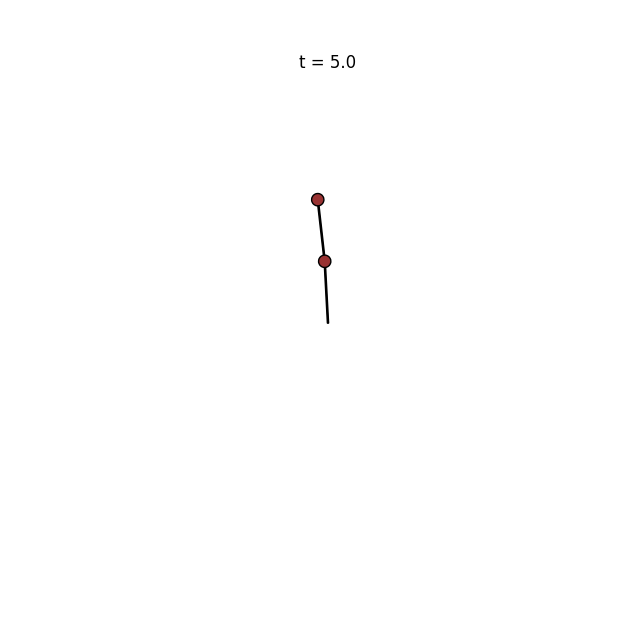

[ 3.12580796  0.04641645  0.03109933 -0.09496759]
[ 3.1516383  -0.08368552 -0.02037687  0.02244495]


In [15]:
duration = 5.0
# Set up a block diagram with the robot (dynamics) and a visualization block.
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0001)

# Load the Acrobot description from URDF file
parser = Parser(plant, scene_graph)
parser.AddModelFromFile(filePath)

# Reduce/remove gravity
plantGravityField = plant.gravity_field()
plantGravityField.set_gravity_vector([0,0,0])

plant.Finalize()

# Linearize the MBP about [pi, 0, 0, 0]
q = [np.pi, 0]
q_dot = [0, 0]

linearize_context = plant.CreateDefaultContext()
plant.SetPositions(linearize_context, q)
plant.SetVelocities(linearize_context, q_dot)
actuation_port = plant.get_actuation_input_port()
actuation_port.FixValue(linearize_context, [0, 0])

# Set up LQR, with high velocity gains to try to ensure that the end state is zero-velocity
# without caring much for the final orientation.
Q = np.diag([0.001, 0.001, 10, 10])
# For testing, high position gains as well.
# Q = np.diag([100, 100, 100, 100])
R = np.identity(2)
lqr_controller = builder.AddSystem(LinearQuadraticRegulator(plant, linearize_context, Q, R,
                                                            input_port_index=actuation_port.get_index()))

# Connect the LQR Controller to MBP
builder.Connect(plant.get_state_output_port(), lqr_controller.get_input_port(0))
builder.Connect(lqr_controller.get_output_port(0), plant.get_actuation_input_port())

# Add a Planar Visualization instead of a 3-D Meshcat Visualization
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, 
                          xlim=[-4., 4.], ylim=[-4., 4.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
            visualizer.get_input_port(0))

# Build the diagram with all the components
diagram = builder.Build()

# Set up a simulator to run the
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
plant_context = plant.GetMyMutableContextFromRoot(context)
actuation_port.FixValue(plant_context, [0, 0])

if not visualizer._show:
    visualizer.start_recording()

for i in range(2):
    context.SetTime(0.)
    randState =  np.array(q+q_dot) + 0.05 * np.random.randn(4,)
    randState[-2:0] = 4 * randState[-2:0]
    print(randState)
    plant_context.SetDiscreteState(randState)
#     plant_context.SetContinuousState(randState)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    AdvanceToAndVisualize(simulator, visualizer, duration)
